## Volume Demand Forecast for Multiple Products Using DeepAR in AWS  

### 1. Project purpose

A company has a large portfolio of products distributed to retailers through agencies. There are thousands of unique agency-SKU/product combinations. In order to plan its production and distribution as well as help agencies with their planning, it is important for the company to have an accurate estimate of demand at SKU level for each agency.

Our purpose is to achieve the following using DeepAR algorithm:
- taking advantage of DeepAR's RNN framework. To predict product demand that's not only trained on their own historical data, but also trained on historical data of other variables(e.g., sales price and promotion price) that have impact on product demand.  
- predicting the monthly demand volume(hectoliters) for each Agency-SKU combination (350 Agency-SKU combinations in total) for year 2018 based on data from 2013-2017.
- handling cold start problems, which is to do volume demand forecast for new Agency-SKU combinations that we don't have any data on.  

### 2. Set up Sagemaker instance and load Data

#### 2.1 Sagemaker instance and S3 setup

In [8]:
from __future__ import print_function
%matplotlib inline
from random import shuffle
import random
import datetime
import os
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# set random seeds for reproducibility
np.random.seed(4216)
random.seed(4216)

In [ ]:
# configure the container image to be used for the region that we are running in. Import the Amazon SageMaker Python SDK and get the deepar container
sagemaker_session = sagemaker.Session()
region_name = boto3.Session().region_name #sagemaker_session.boto3_region_name 
# region_name = "us-east-1"
image_name = sagemaker.image_uris.retrieve(framework="forecasting-deepar", region=region_name)


In [30]:
#Get the execution role for the notebook instance. This is the IAM role created for the notebook instance that creates an access b/w S3 bucket and this instance
role = get_execution_role()
#load our data saved in S3 bucket
df_historical_volume = pd.read_csv("s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/historical_volume.csv")
df_price_sales_promotion = pd.read_csv("s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/price_sales_promotion.csv")


#### 2.2 Loading data
We have two datasets available for analysis. 
- historical_volume.csv : holds volume(hectoliters) sales data at Agency-SKU-month level from Jan 2013 to Dec 2017
- price_sales_promotion.csv : Holds price (dollar/hectoliters), sales(dollar/hectoliters) and promotion(dollar/hectoliter) at Agency-SKU-month level from Jan 2013 to Dec 2017. The relationship between these 3 variables: price = sales + promotion

Data source: https://www.kaggle.com/utathya/future-volume-prediction 

In [34]:
df_historical_volume.sample(3)

,Agency,SKU,YearMonth,Volume
12147,Agency_28,SKU_01,201704,36.828
11652,Agency_26,SKU_03,201604,0.000
67,Agency_50,SKU_01,201301,1144.800


In [35]:
df_price_sales_promotion.sample(3)

,Agency,SKU,YearMonth,Price,Sales,Promotions
14719,Agency_29,SKU_05,201407,1847.22027,1793.835005,53.385265
7573,Agency_25,SKU_03,201403,1332.12766,1062.636702,269.490958
6114,Agency_58,SKU_02,201708,1674.31615,1338.204383,336.111767


### 3. Data cleaning
To manipulate data to the correct format required by SageMaker DeepAR 

#### 3.1 Combining two datasets
Combine two datasets by 'Agency', 'SKU', 'YearMonth'.

In [373]:
df1 = df_historical_volume.sort_values(by = ['Agency', 'SKU', 'YearMonth'], inplace = False, ignore_index = True)
df2 = df_price_sales_promotion.sort_values(by = ['Agency', 'SKU', 'YearMonth'], inplace = False, ignore_index = True)

df = pd.merge(df1, df2, how = 'inner', on = ['Agency', 'SKU', 'YearMonth'])

df['time'] = pd.to_datetime(df['YearMonth'], format = '%Y%m')

#### 3.2 Label encoding 
Use label encoders for 2 category variables-- Agency and SKU since DeepAR only accepts categories represented by number. There are 58 different agencies and 25 different SKUs. 

In [ ]:
from sklearn import preprocessing
#use label encoding to encode 'Agency' and 'SKU' to numbers 
agency_le = preprocessing.LabelEncoder()
df['Agency_le'] = agency_le.fit_transform(df['Agency'])
sku_le = preprocessing.LabelEncoder()
df['SKU_le'] = sku_le.fit_transform(df['SKU'])

agency_label = agency_le.transform(agency_le.classes_)
agency_name = agency_le.classes_
agency_label_encoder = pd.DataFrame(zip(agency_name, agency_label), columns = ['agency_name', 'agency_label']).to_string(index = False)
sku_label = sku_le.transform(sku_le.classes_)
sku_name = sku_le.classes_
sku_label_encoder = pd.DataFrame(zip(sku_name, sku_label), columns = ['sku_name', 'sku_label']).to_string(index = False)

#### 3.3 Transforming the data format
We start to transform data from a vertical format to a dictionary format using group_by and merge etc. After grouping the data by 'Agency' and 'SKU', we can see we have 350 time series that we will need to predict simultaneously.

In [300]:
group_by = df.groupby(['Agency_le', 'SKU_le']) # cat: 350 agency-SKU combination time series in total
volume_series = group_by['Volume'].apply(list).reset_index(name = 'volume')
sales_series = group_by['Sales'].apply(list).reset_index(name = 'sales')
promotion_series = group_by['Promotions'].apply(list).reset_index(name = 'promotions')

df_merge = pd.merge(volume_series, sales_series, how= 'inner', on= ['Agency_le','SKU_le']) 
df_merge2 = pd.merge(df_merge, promotion_series, how = 'inner', on = ['Agency_le','SKU_le'])
#df_merge2['cat_agency_sku'] = df_merge2[['Agency_le', 'SKU_le']].apply(lambda x: ','.join(x.map(str)), axis=1)
df_merge2['cat_agency_sku'] = df_merge2[['Agency_le', 'SKU_le']].apply(lambda x: list(x), axis=1)

#check the lengths of each dynamic features.len should be 60.

np.where(df_merge2.volume.apply(lambda x: len(x)) != 60)
np.where(df_merge2.sales.apply(lambda x: len(x)) !=60)
np.where(df_merge2.promotions.apply(lambda x: len(x)) !=60)

(array([], dtype=int64),)

In [754]:
# monthly volume, sales and promotions for each agency and sku averaged over 2013-2017
Agency_SKU = df.groupby(['Agency','SKU'])
Agency_SKU_mean = Agency_SKU['Volume'].mean().reset_index(name = 'average_volume')
Agency_SKU_mean.sample(3)

,Agency,SKU,average_volume
87,Agency_16,SKU_04,1040.106178
9,Agency_02,SKU_04,4078.060653
181,Agency_31,SKU_03,592.906040


#### 3.4 Spliting data to training and test sets
- training set: 48-month data from 2013-01 to 2016-12
- test set: 12-month data from 2017-01 to 2017-12


In [303]:
df_merge2['sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['sales']),np.array(x['promotions'])]),axis = 1)
df_merge2['training_volume'] = df_merge2['volume'].apply(lambda x: x[:48])
df_merge2['training_sales'] = df_merge2['sales'].apply(lambda x: x[:48])
df_merge2['training_promotions'] = df_merge2['promotions'].apply(lambda x: x[:48])
df_merge2['training_sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['training_sales']),np.array(x['training_promotions'])]),axis = 1)

df_merge2['test_volume'] = df_merge2['volume'].apply(lambda x: x[48:])
df_merge2['test_sales'] = df_merge2['sales'].apply(lambda x: x[48:])
df_merge2['test_promotions'] = df_merge2['promotions'].apply(lambda x: x[48:])
df_merge2['test_sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['test_sales']),np.array(x['test_promotions'])]),axis = 1)

# create the dynamic_feat: sales and promotions for batch transform data. 
df_merge2['batch_sales'] = df_merge2.apply(lambda x: x.sales + x.test_sales, axis = 1)
df_merge2['batch_promotions'] = df_merge2.apply(lambda x: x.promotions + x.test_promotions, axis = 1)
df_merge2['batch_sales_promotions'] = df_merge2.apply(lambda x: np.vstack([np.array(x['batch_sales']),np.array(x['batch_promotions'])]),axis = 1)

In [757]:
full_df_clean = pd.concat([df_merge2,Agency_SKU_mean], axis = 1)
full_df_clean.sample(3)

,Agency_le,SKU_le,volume,sales,promotions,cat_agency_sku,training_volume,training_sales,training_promotions,training_sales_promotions,...,test_sales,test_promotions,test_sales_promotions,batch_sales,batch_promotions,batch_sales_promotions,sales_promotions,Agency,SKU,average_volume
126,20,0,"[42.443999999999996, 39.635999999999996, 33.69...","[1060.82236, 1059.24404, 1096.6482369999999, 1...","[106.17764, 107.75596000000002, 109.338742, 11...","[20, 0]","[42.443999999999996, 39.635999999999996, 33.69...","[1060.82236, 1059.24404, 1096.6482369999999, 1...","[106.17764, 107.75596000000002, 109.338742, 11...","[[1060.82236, 1059.24404, 1096.6482369999999, ...",...,"[1313.624556, 1321.591404, 1313.194334, 1239.6...","[316.990373, 322.471096, 330.86816600000003, 4...","[[1313.624556, 1321.591404, 1313.194334, 1239....","[1060.82236, 1059.24404, 1096.6482369999999, 1...","[106.17764, 107.75596000000002, 109.338742, 11...","[[1060.82236, 1059.24404, 1096.6482369999999, ...","[[1060.82236, 1059.24404, 1096.6482369999999, ...",Agency_23,SKU_01,41.333400
136,21,4,"[433.6893, 436.2453, 558.8055, 560.4669, 639.0...","[1195.790835, 1197.118984, 1236.672614, 1291.5...","[114.385222, 113.057073, 116.23699599999999, 1...","[21, 4]","[433.6893, 436.2453, 558.8055, 560.4669, 639.0...","[1195.790835, 1197.118984, 1236.672614, 1291.5...","[114.385222, 113.057073, 116.23699599999999, 1...","[[1195.790835, 1197.118984, 1236.672614, 1291....",...,"[1520.4862, 1476.422039, 1461.040886, 1387.006...","[240.48908500000002, 279.967596, 287.832221, 3...","[[1520.4862, 1476.422039, 1461.040886, 1387.00...","[1195.790835, 1197.118984, 1236.672614, 1291.5...","[114.385222, 113.057073, 116.23699599999999, 1...","[[1195.790835, 1197.118984, 1236.672614, 1291....","[[1195.790835, 1197.118984, 1236.672614, 1291....",Agency_24,SKU_05,507.508395
330,55,2,"[229.68900000000002, 273.258, 371.2248, 298.38...","[1164.8596730000002, 1152.550517, 1208.036876,...","[96.988671, 112.558066, 72.03876600000001, 149...","[55, 2]","[229.68900000000002, 273.258, 371.2248, 298.38...","[1164.8596730000002, 1152.550517, 1208.036876,...","[96.988671, 112.558066, 72.03876600000001, 149...","[[1164.8596730000002, 1152.550517, 1208.036876...",...,"[1368.17466, 1415.8808390000002, 1394.083991, ...","[292.504778, 259.806903, 296.47146000000004, 3...","[[1368.17466, 1415.8808390000002, 1394.083991,...","[1164.8596730000002, 1152.550517, 1208.036876,...","[96.988671, 112.558066, 72.03876600000001, 149...","[[1164.8596730000002, 1152.550517, 1208.036876...","[[1164.8596730000002, 1152.550517, 1208.036876...",Agency_58,SKU_03,301.496200


#### 3.5 Transforming training and test sets to dictionary format
Transforming data to dictionary format to be prepared for json line format required by DeepAR

In [422]:
start_training = pd.Timestamp("2013-01-01 00:00:00")


training_data = []
for _,row in df_merge2.iterrows():
    training_dic = {"start": str(start_training),
           "target": row['training_volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['training_sales_promotions'] 
           }
    training_data.append(training_dic)

    

test_data = []
for _,row in df_merge2.iterrows():
    test_dic = {"start": str(start_training),
           "target": row['volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['sales_promotions'] 
           }
    test_data.append(test_dic)


# create batch transform input: predicting volume demand for each SKU and agency pair for 201801 - 201812 given dynamic_feat--'sales' and 'promotions' remain the same as of 2017
batch_transform_input = []
for _,row in df_merge2.iterrows():
    batch_dic = {"start": str(start_training),
           "target": row['volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['batch_sales_promotions'] 
           }
    batch_transform_input.append(batch_dic)

    
    
#dataset for calculating predicted volume for each series in the test set
data_for_calculating_predicted = []
for _,row in df_merge2.iterrows():
    calculating_predicted_dic = {"start": str(start_training),
           "target": row['training_volume'],
           "cat": row['cat_agency_sku'],
           "dynamic_feat": row['sales_promotions'] 
           }
    data_for_calculating_predicted.append(calculating_predicted_dic)

#### 3.6 Transforming dictionary to json lines

In [423]:
import json 

# correct np narray
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# convert to json lines: each line is a json object
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d, cls=NumpyEncoder).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)
write_dicts_to_file("batch_transform_input.json", batch_transform_input)
write_dicts_to_file("data_for_calculating_predicted.json", data_for_calculating_predicted)

#### 3.7 Copying the local json lines to S3 where DeepAR can access

In [424]:
import logging
import boto3
from botocore.exceptions import ClientError


def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [425]:
BUCKET_NAME = 'sagemaker-us-east-2-939910653043'
upload_file("train.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/data/train.json")
upload_file("test.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/data/test.json")
upload_file("batch_transform_input.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/batch_transform_input.json")
upload_file("data_for_calculating_predicted.json", BUCKET_NAME, object_name= "product-demand-forecast-deepar/data_for_calculating_predicted.json")

True

In [541]:
# have a look to what was just written to S3. Now data has been successfully customized to json line which is required by DeepAR
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(BUCKET_NAME + "/product-demand-forecast-deepar/data/test.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:500] + "...")

{"start": "2013-01-01 00:00:00", "target": [80.676, 98.064, 133.704, 147.312, 175.608, 180.792, 149.796, 161.136, 147.744, 149.364, 95.36399999999999, 104.544, 100.54799999999999, 123.552, 125.17200000000001, 70.524, 21.924, 66.744, 89.1, 107.352, 100.87200000000001, 113.292, 68.148, 75.492, 41.58, 58.32, 87.37200000000001, 81.0, 91.90799999999999, 86.616, 135.0, 97.632, 103.464, 92.016, 54.864, 40.608000000000004, 55.836000000000006, 52.812, 88.992, 66.63600000000001, 49.14, 4.32, 54.4319999999...


### 4. Train the DeepAR model

#### 4.1 Training a model
After specifying the hyperparameters below, we trained a DeepAR model with the training set. Meanwhile, the built-in function let us test the model with the test set. As we can see below, the test error was obtained: test RMSE <loss>=759.711203642

In [ ]:
s3_output_path = "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/output"

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge',
    base_job_name='deepar-volume-demand-forecast',
    output_path=s3_output_path
)

In [432]:
hyperparameters = {
    "time_freq":"M" ,
    "cardinality" : "auto",
    "num_dynamic_feat":"auto",
    "epochs": "162",       
    "dropout_rate": "0.1",
    "embedding_dimension" : "10",
    "likelihood":"gaussian",
    "num_cells": "94",
    "num_layers": "4",
    "mini_batch_size":"256",
    #"learning_rate": "1e-3",
    "num_eval_samples": "100",
    "test_quantiles": "[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]",
    "context_length": "12",
    "prediction_length": "12"}
estimator.set_hyperparameters(**hyperparameters)

In [ ]:
%%time
data_channels = {
    "train": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train.json",
    "test": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test.json"
}

estimator.fit(inputs=data_channels, wait=True)

#### 4.2 Training multiple DeepAR models with auto hyperparamter Tuning function
We chose 5 hyperparameters considered to having bigger impact on the performance of the model such as learning rate and minibatch size. Then, we searched the best values of them within the specified ranges to have the lowest test error. We trained 6 models in total and the best model has the test RMSE: 792.3036499023438 which is higher than that of the previous model. 

In [ ]:
s3_output_path_auto = "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/output_auto"

estimator_auto = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c5.2xlarge',
    base_job_name='deepar-volume-demand-forecast-autotuning',
    output_path=s3_output_path_auto
)

In [440]:
hyperparameters_auto = {
    "time_freq":"M" ,
    "cardinality" : "auto",
    "num_dynamic_feat":"auto",
    #"epochs": "162",
    "dropout_rate": "0.1",
    "embedding_dimension" : "10",
    "likelihood":"gaussian",
    #"num_cells": "50",
    #"num_layers": "4",
    #"mini_batch_size":"256",
    #"learning_rate": "1e-3",
    "num_eval_samples": "100",
    "test_quantiles": "[0.1, 0.5, 0.9]",
    #"context_length": "12",
    "prediction_length": "12"}
estimator_auto.set_hyperparameters(**hyperparameters_auto)

In [441]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter


hyperparameter_ranges = {"learning_rate": ContinuousParameter(1e-4, 1e-1),
                         "mini_batch_size": IntegerParameter(128, 350),
                         "epochs": IntegerParameter(10, 500),
                         "context_length":IntegerParameter(12, 24),
                         "num_cells":IntegerParameter(30, 200),
                         "num_layers": IntegerParameter(1, 8)
                        }

In [ ]:
objective_metric_name = "test:RMSE" # start with "test:"  can be found on the website


# the order of the params in the hyperparametertuner matters
tuner = HyperparameterTuner(estimator_auto,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions=None,
                            strategy="Bayesian",
                            objective_type="Minimize",
                            max_jobs=6,
                            max_parallel_jobs=3,
                            tags=None,
                            base_tuning_job_name='deepar-auto-tuner')

data_channels = {
    "train": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train.json",
    "test": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test.json"}

tuner.fit(inputs = data_channels,logs=True, include_cls_metadata=False)

#### 4.3 Exploring to train the models using Auto-tuning with a warm_start
We wanted to keep improving the performace of our model, so we kept tuning the parameters for 2 more models with a warm start from the 6 models we previously auto-tuned. The test errors of the 2 models obtained are even higher. Use warm start to start a hyperparameter tuning job using one or more previous tuning jobs as a starting point. 

In the future, we should consider exploring better ranges of hyperparamters for auto-tuning and training more models to get better results, but for now we will just use the model with the lowest test error of all models. 

In [ ]:
from sagemaker.tuner import WarmStartConfig,WarmStartTypes

# Warm start tuning jobs typically take longer to start than standard hyperparameter tuning jobs, 
# because the results from the parent jobs have to be loaded before the job can start. The increased time depends on the total number of training jobs launched by the parent jobs.
parent_tuning_job_name = "deepar-auto-tuner-201108-1008"
warm_start_config = WarmStartConfig(WarmStartTypes.IDENTICAL_DATA_AND_ALGORITHM, parents={parent_tuning_job_name})


In [ ]:
objective_metric_name = "test:RMSE" # start with "test:" that can be found on the website


# the order of the params in the hyperparametertuner matters
tuner_warm_start = HyperparameterTuner(estimator_auto,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions=None,
                            strategy="Bayesian",
                            objective_type="Minimize",
                            max_jobs=2,
                            max_parallel_jobs=2,
                            tags=None,
                            base_tuning_job_name='deepar-warm-start',
                            warm_start_config=warm_start_config)

data_channels = {
    "train": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/train.json",
    "test": "s3://sagemaker-us-east-2-939910653043/product-demand-forecast-deepar/data/test.json"}

tuner_warm_start.fit(inputs = data_channels,logs=True, include_cls_metadata=False)

In [ ]:
# we did auto hyperparameter tuning jobs with a warm start twice. It shows both of them below.
tuning_job_name = 'deepar-warm-start-201108-1212'
tuner_parent = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
full_df = tuner_parent.dataframe()
# full_df.sort_values(['FinalObjectiveValue'], ascending=True)

#### 4.4 Plotting actual vs. predicted demand volumes in 2017 using the best model
We plotted 20 graphs for 20 Agency-SKU combinations below. Each graph has time(month/2017) as x-axis and demand volume(hectoliters) as y-axis. 

The black line is actual volume and the red line is the predicted volume averaged by all samples, which is the mean prediction. Mean prediction is only a point estimate, and we can see some predicted values can't catch the trend.

In [ ]:
# use the best model to predict the data in the testset using batch transform method
PREFIX = "product-demand-forecast-deepar"

batch_input_test = 's3://{}/{}/data_for_calculating_predicted'.format(BUCKET_NAME, PREFIX)

# The location to store the results of the batch transform job
batch_output_test = 's3://{}/{}/predicted_values_testset'.format(BUCKET_NAME, PREFIX)

#set environment: only include prediction averaged over 200 samples
env ={ "DEEPAR_INFERENCE_CONFIG" : "{ \"num_samples\": 200, \"output_types\": [\"mean\"] }"}


transformer_test = sagemaker.transformer.Transformer(model_name = 'volume-demand-deepar-model',instance_count=1, instance_type='ml.m4.xlarge',strategy = 'SingleRecord',env = env,output_path=batch_output_test)


# SplitType must be set according to the ContentType of the input data.
transformer_test.transform(data=batch_input_test, data_type='S3Prefix', content_type='application/jsonlines', split_type='Line')


In [207]:
# change the predictions output to correct json format and make dataframe 
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(BUCKET_NAME + "/product-demand-forecast-deepar/predicted_values_testset/data_for_calculating_predicted.json.out", 'rb') as f:
    pred = json.loads("[" + f.read().decode("utf-8").replace("}{", "},\n{") + "]") #json.loads() only takes str and return dic
# combine the predictions output to to clean full dataset we have
pred_test = pd.DataFrame(pred).rename(columns={"mean": "predicted_volume"})
full_data = pd.concat([full_df_clean ,pred_test], axis = 1).rename(columns={"test_volume": "actual_volume"})

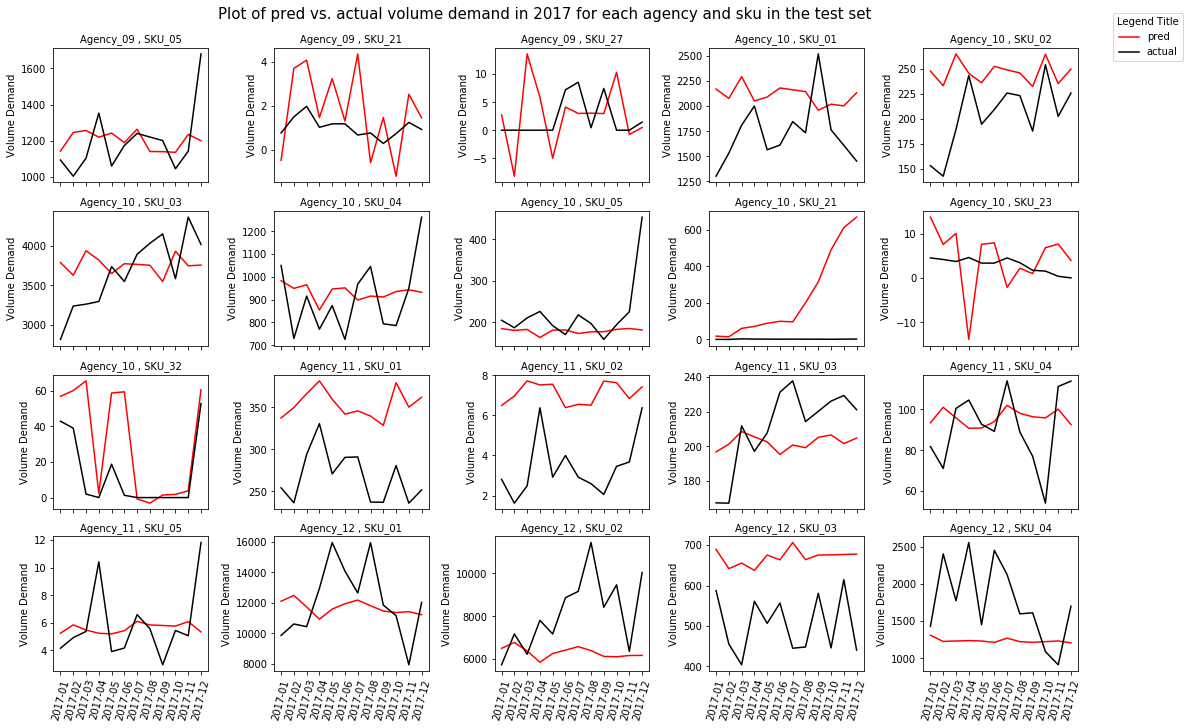

In [784]:
# plot actual vs. pred for 20 agency-sku combinations for the testset
test_period_range = pd.period_range(start='2017-01-01', end='2017-12-01', freq='M').strftime('%Y-%m')

import matplotlib.pyplot as plt

def compare_pred_actual_plot(ax, row):
    ax.plot(test_period_range,full_data.loc[row,'predicted_volume'], color = 'red', label = 'pred')
    ax.plot(test_period_range,full_data.loc[row,'actual_volume'],color = 'black', label = 'actual')
    ax.set_title(full_data.loc[row,'Agency']+' , '+full_data.loc[row,'SKU'] , fontsize=10)
    ax.set_ylabel('Volume Demand', fontsize=10)
    ax.set_xticklabels(test_period_range, rotation=75)


fig, axs = plt.subplots(nrows=4, ncols=5, constrained_layout=True,figsize=(15,10),sharex=True)

for ax, row in zip(axs.flat,range(50,70,1)): 
    compare_pred_actual_plot(ax, row)
    
fig.legend( labels = ['pred','actual'],bbox_to_anchor=(0.8, 0.8, 0.3, 0.2), loc="upper right", title="Legend Title")
fig.suptitle('Plot of pred vs. actual volume demand in 2017 for each agency and sku in the test set', fontsize=15)
fig.savefig('Plot of pred vs. actual volume demand in 2017 50-70.png')


#### 4.5 Adding 10%-90% quantiles to the actual-pred plot
I obtained predicted 10% and 90% quantiles using batch transform, so we can add the 80% interval to the plot to better catch the trend of ther predicted demand. We can see below that the 80% intervals of most plots catch the general trend of the actual values. An interval like this can help better prepare for the demand.

Details: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html

In [ ]:
#get predicted 10% and 90% quantiles for volume demand in test set using batch transform
BUCKET_NAME = 'sagemaker-us-east-2-939910653043'
PREFIX = "product-demand-forecast-deepar"
batch_input_test = 's3://{}/{}/data_for_calculating_predicted'.format(BUCKET_NAME, PREFIX)
batch_output_test_quantiles= 's3://{}/{}/predicted_values_testset0.1_0.9quantiles'.format(BUCKET_NAME, PREFIX)

#set environment: only include prediction averaged over 200 samples
env_quantiles ={ "DEEPAR_INFERENCE_CONFIG" : "{ \"num_samples\": 200, \"output_types\": [\"quantiles\"] ,\"quantiles\": [\"0.1\",\"0.9\"]}"}
transformer_test_quantiles = sagemaker.transformer.Transformer(model_name = 'volume-demand-deepar-model',instance_count=1, instance_type='ml.m4.xlarge',strategy = 'SingleRecord',env = env_quantiles,output_path=batch_output_test_quantiles)
# SplitType must be set according to the ContentType of the input data.
transformer_test_quantiles.transform(data=batch_input_test, data_type='S3Prefix', content_type='application/jsonlines', split_type='Line')

In [112]:
#change the output from batch trnsform to the correct format and combine to the full data set we use to plot
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(BUCKET_NAME + "/product-demand-forecast-deepar/predicted_values_testset0.1_0.9quantiles/data_for_calculating_predicted.json.out", 'rb') as f:
    pred_quantiles = json.loads("[" + f.read().decode("utf-8").replace("}{", "},\n{") + "]") #json.loads() only takes str and return dic

df_quan = pd.DataFrame(pred_quantiles)
df_quan['pred_10p_quantile'] = df_quan['quantiles'].apply(lambda x: x.get('0.1'))
df_quan['pred_90p_quantile'] = df_quan['quantiles'].apply(lambda x: x.get('0.9'))
#turn negative values in 10 percent and 90 percent quantile to zero 
for row in range(0,350):
    df_quan['pred_10p_quantile'][row] = [0 if x<0 else x for x in df_quan['pred_10p_quantile'][row]]
    df_quan['pred_90p_quantile'][row] = [0 if x<0 else x for x in df_quan['pred_90p_quantile'][row]] 
full_data_final = pd.concat([full_data ,df_quan[['pred_10p_quantile','pred_90p_quantile']]], axis = 1)
full_data_final = full_data_final.loc[:, ~full_data_final.columns.str.contains('^Unnamed')].rename(columns={"test_volume": "actual_volume"}) #delete unnamed index col
full_data_final.to_csv('clean_full_data_final.csv')
full_data_final.sample(3)


,Agency_le,SKU_le,volume,sales,promotions,cat_agency_sku,training_volume,training_sales,training_promotions,training_sales_promotions,...,batch_sales,batch_promotions,batch_sales_promotions,sales_promotions,Agency,SKU,average_volume,predicted_volume,pred_10p_quantile,pred_90p_quantile
227,39,0,"[239.65200000000002, 286.092, 310.824, 341.928...","[1103.174258, 1114.252769, 1146.799966, 1182.9...","[29.763241999999998, 18.684731, 17.83296499999...","[39, 0]","[239.65200000000002, 286.092, 310.824, 341.928...","[1103.174258, 1114.252769, 1146.799966, 1182.9...","[29.763241999999998, 18.684731, 17.83296499999...",[[1103.174258 1114.252769 1146.799966 1182.995...,...,"[1103.174258, 1114.252769, 1146.799966, 1182.9...","[29.763241999999998, 18.684731, 17.83296499999...",[[1103.174258 1114.252769 1146.799966 1182.995...,[[1103.174258 1114.252769 1146.799966 1182.995...,Agency_42,SKU_01,357.937200,"[407.549987793, 383.6038818359, 373.1228637695...","[241.6286621094, 222.1826934814, 237.720062255...","[563.3975830078, 593.4237060547, 593.962524414..."
235,40,3,"[372.537, 459.441, 592.0335, 364.9329, 562.831...","[1555.3026619999998, 1601.1089060000002, 1672....","[180.344799, 134.42659, 120.78884599999999, 21...","[40, 3]","[372.537, 459.441, 592.0335, 364.9329, 562.831...","[1555.3026619999998, 1601.1089060000002, 1672....","[180.344799, 134.42659, 120.78884599999999, 21...",[[1555.302662 1601.108906 1672.556516 1634....,...,"[1555.3026619999998, 1601.1089060000002, 1672....","[180.344799, 134.42659, 120.78884599999999, 21...",[[1555.302662 1601.108906 1672.556516 1634....,[[1555.302662 1601.108906 1672.556516 1634....,Agency_43,SKU_04,312.870603,"[328.5222167969, 274.8731689453, 283.605224609...","[44.4495239258, 99.048614502, 54.1541442871, 6...","[592.1439208984, 589.9252319336, 570.370849609..."
285,48,2,"[3513.3534, 3457.09425, 3708.77925, 4867.884, ...","[1230.196357, 1241.882108, 1273.2891539999998,...","[100.893918, 88.713004, 91.546317, 78.443748, ...","[48, 2]","[3513.3534, 3457.09425, 3708.77925, 4867.884, ...","[1230.196357, 1241.882108, 1273.2891539999998,...","[100.893918, 88.713004, 91.546317, 78.443748, ...",[[1230.196357 1241.882108 1273.289154 1324.005...,...,"[1230.196357, 1241.882108, 1273.2891539999998,...","[100.893918, 88.713004, 91.546317, 78.443748, ...",[[1230.196357 1241.882108 1273.289154 1324.005...,[[1230.196357 1241.882108 1273.289154 1324.005...,Agency_51,SKU_03,4768.757063,"[5096.9638671875, 4561.5893554688, 4594.428710...","[3247.6044921875, 3326.0625, 3175.91796875, 29...","[6360.6982421875, 6210.1865234375, 6193.046875..."


In [1]:
# fix list stored as string issue using converters, then we can use them to plot. List objects have a string representation, allowing them to be stored as .csv files. Loading the .csv will then yield that string representation. reference: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
data_for_plot = pd.read_csv('clean_full_data_final.csv',converters={'actual_volume': eval,'predicted_volume': eval,'pred_10p_quantile': eval,'pred_90p_quantile': eval})



test_period_range = pd.period_range(start='2017-01-01', end='2017-12-01', freq='M').strftime('%Y-%m')
def compare_pred_actual_plot(ax, row):
    ax.plot(test_period_range,data_for_plot.loc[row,'predicted_volume'], color = 'red', label = 'pred_mean')
    ax.plot(test_period_range,data_for_plot.loc[row,'actual_volume'], color = 'black', label = 'actual')
    #ax.plot(test_period_range,data_for_plot.loc[row,'pred_10p_quantile'], color = 'green', label = '10')
    #ax.plot(test_period_range,data_for_plot.loc[row,'pred_90p_quantile'], color = 'green', label = '90')    
    ax.fill_between(test_period_range,data_for_plot.loc[row,'pred_10p_quantile'],data_for_plot.loc[row,'pred_90p_quantile'],facecolor='green',color = 'green',alpha=0.2,label = '80% interval',linewidth=[2,2])
    ax.set_title(data_for_plot.loc[row,'Agency']+' , '+data_for_plot.loc[row,'SKU'] , fontsize=10)
    ax.set_ylabel('Volume Demand', fontsize=10)
    ax.set_xticklabels(test_period_range, rotation=75)

fig, axs = plt.subplots(nrows=4, ncols=5, constrained_layout=True,figsize=(15,10),sharex=True)

for ax, row in zip(axs.flat,range(50,70,1)): 
    compare_pred_actual_plot(ax, row)
    
fig.legend( labels = ['pred','actual','80% interval'],bbox_to_anchor=(0.8, 0.8, 0.3, 0.2), loc="upper right", title="Legend Title")
fig.suptitle('Plot of pred vs. actual volume demand in 2017 for each agency and sku in the test set', fontsize=15)
fig.savefig('Plot of pred vs. actual volume demand in 2017 50-70 with 80% interval.png')   

data_for_plot

NameError: name 'pd' is not defined

### 5. Making 12-month predictions with the best model for year 2018
Feeding the data we have from 2013-01 to 2017-12 to the model(test RMSE =759.711203642), we made a 12 month prediction for 2018 for 350 Agency-SKU combinations using batch transform method. We set dynamic features for sales and promotions for 2018 the same as the year 2017 for the 350 time series. The predictions output for 2018 was obtained and stored in S3 bucket.

In [ ]:
# predict volume demand for every SKU and agency pair for Jan, 2018 - Dec, 2018 given setting sales and promotions the same as the previous 12 months respectively 
PREFIX = "product-demand-forecast-deepar"

batch_input_predict2018 = 's3://{}/{}/batch_transform_input'.format(BUCKET_NAME, PREFIX)

# The location to store the results of the batch transform job
batch_output_predict2018 = 's3://{}/{}/batch_inference_predict2018'.format(BUCKET_NAME, PREFIX)

#set environment: only include prediction averaged over 200 samples
env ={ "DEEPAR_INFERENCE_CONFIG" : "{ \"num_samples\": 100, \"output_types\": [\"mean\"] }"}
transformer_predict2018 = sagemaker.transformer.Transformer(model_name = 'volume-demand-deepar-model',instance_count=1, instance_type='ml.m4.xlarge',strategy = 'SingleRecord',env = env,output_path=batch_output_predict2018)
# SplitType must be set according to the ContentType of the input data.
transformer_predict2018.transform(data=batch_input_predict2018, data_type='S3Prefix', content_type='application/jsonlines', split_type='Line')

transformer_predict2018.wait()

In [213]:
#predictor.delete_endpoint()
#tuner_warm_start.best_training_job()
#tuner_warm_start.best_estimator()